# Laboratorium 10
## Równania różniczkowe - spectral bias
Iga Antonik, Helena Szczepanowska

# Zadanie 

![alt text](img/zad1.png) </br>

![alt text](img/zad2.png) </br>

## Rozwiązanie
### Biblioteki

In [61]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

### Właściwe rozwiązanie

In [62]:
def exact_solution(x, w):
    return np.sin(w * x) / w

### Definicja sieci neuronowej w PyTorch

In [63]:
class FCN(nn.Module):
    "Defines a fully-connected network in PyTorch"
    def __init__(self, N_INPUT, N_OUTPUT, N_HIDDEN, N_LAYERS):
        super().__init__()
        activation = nn.Tanh
        self.fcs = nn.Sequential(*[
                        nn.Linear(N_INPUT, N_HIDDEN),
                        activation()])
        self.fch = nn.Sequential(*[
                        nn.Sequential(*[
                            nn.Linear(N_HIDDEN, N_HIDDEN),
                            activation()]) for _ in range(N_LAYERS-1)])
        self.fce = nn.Linear(N_HIDDEN, N_OUTPUT)
        
    def forward(self, x):
        x = self.fcs(x)
        x = self.fch(x)
        x = self.fce(x)
        return x
    

### Funkcja obliczająca rozwiązanie

In [64]:

def run(train_num, test_num, w, pinn_config):
    torch.manual_seed(123)
     # define a neural network to train
    pinn = FCN(*pinn_config)
    
    # define boundary points, for the boundary loss
    x_boundary = torch.tensor(0.).view(-1,1).requires_grad_(True)
    
    # define training points over the entire domain, for the physics loss
    x_physics = torch.linspace(-2*np.pi, 2*np.pi, train_num).view(-1,1).requires_grad_(True)# (30, 1)
    
    # train the PINN
    x_test = torch.linspace(-2*np.pi, 2*np.pi, test_num).view(-1,1)
    u_exact = exact_solution(x_test, w)
    optimiser = torch.optim.Adam(pinn.parameters(), lr=1e-3)
    
    losses = []
    errors = []

    
    for i in range(50_001):
        optimiser.zero_grad()

        # compute boundary loss
        u = pinn(x_boundary)# (1, 1)
        loss_ic = (torch.squeeze(u) - 0)**2

        # compute physics loss
        u = pinn(x_physics)# (30, 1)
        dudx = torch.autograd.grad(u, x_physics, torch.ones_like(u), create_graph=True)[0]# (30, 1)
        residual = dudx - torch.cos(w * x_physics)
        loss_r = torch.mean(residual**2)

        # backpropagate joint loss, take optimiser step
        loss = loss_ic + loss_r
        losses.append(loss.detach().numpy())
        loss.backward()
        optimiser.step()

        # copmute error
        u = pinn(x_test).detach()
        error = np.abs(u - u_exact) / u_exact
        errors.append(error.detach().numpy())

        # plot the result as training progresses
        if i % 5000 == 0: 
            plt.figure(figsize=(6,2.5))
            plt.scatter(x_physics.detach()[:,0], 
                        torch.zeros_like(x_physics)[:,0], s=20, lw=0, color="tab:green", alpha=0.6)
            plt.scatter(x_boundary.detach()[:,0], 
                        torch.zeros_like(x_boundary)[:,0], s=20, lw=0, color="tab:red", alpha=0.6)
            plt.plot(x_test[:,0], u_exact[:,0], label="Exact solution", color="tab:grey", alpha=0.6)
            plt.plot(x_test[:,0], u[:,0], label="PINN solution", color="tab:green")
            plt.title(f"Training step {i}")
            plt.legend()
            plt.show()
            
    return x_test, u_exact, u, losses, errors
    

### Funkcje do rysowania wykresów

In [83]:
def plot_solution(x, true, pred, w, layers, neurons):
    plt.figure(figsize=(6,2.5))
    plt.plot(x[:,0], true[:,0], label="Exact solution", color="tab:grey", alpha=0.6)
    plt.plot(x[:,0], pred[:,0], label="PINN solution", linestyle = "-", color="orange")
    plt.title(f"Solution for w = {w}, layers = {layers}, neurons = {neurons}")
    plt.legend()
    plt.show()

def plot_losses(losses, w, layers, neurons):
    plt.plot(losses, color='tab:red')
    plt.xlabel('Epochs')
    plt.ylabel("Loss")
    plt.title(f'Loss function for w = {w}, layers = {layers}, neurons = {neurons}')
    plt.show()


def plot_errors(x, exact, predicted, w, layers, neurons):
    plt.plot(x, np.abs(exact - predicted), color='tab:blue')
    plt.yscale('log')
    plt.xlabel('x')
    plt.ylabel('Error')
    plt.title(f'Absolute error w = {w}, layers = {layers}, neurons = {neurons}')
    plt.show()

## Podpunkt (a) $\omega$ = 1

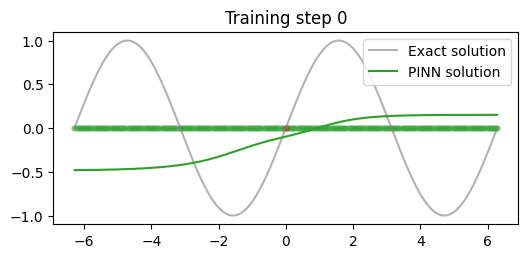

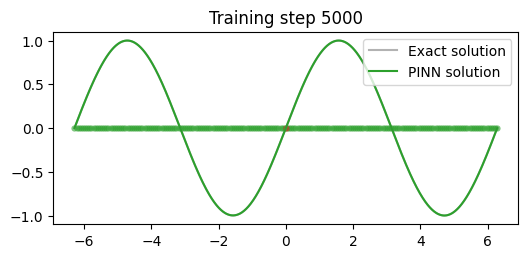

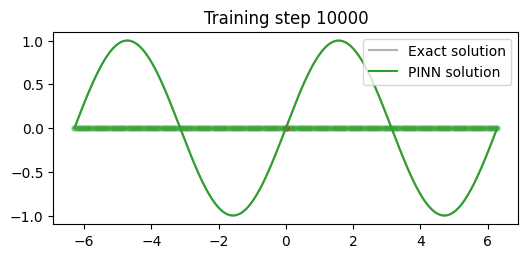

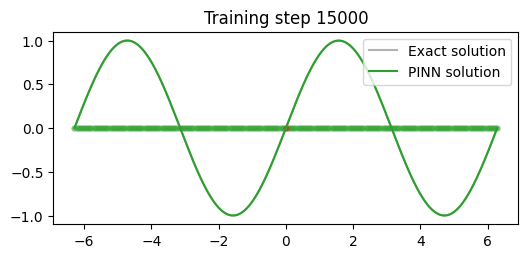

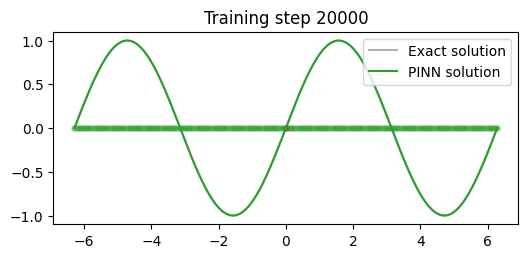

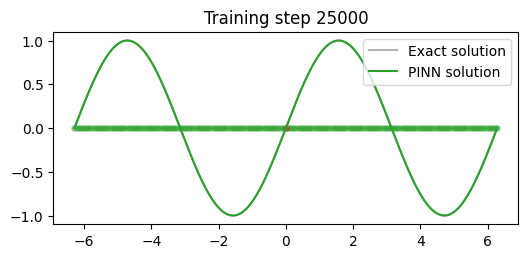

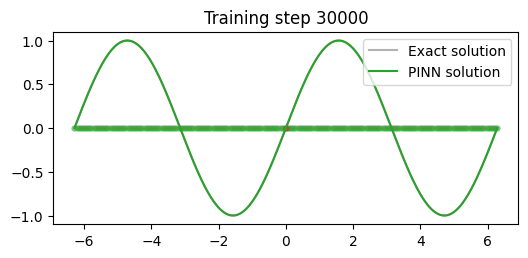

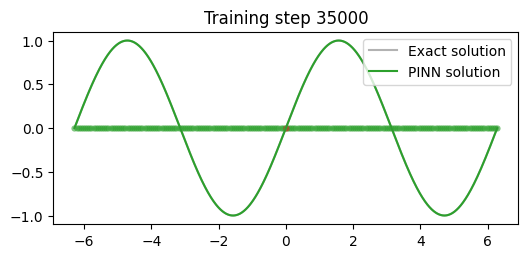

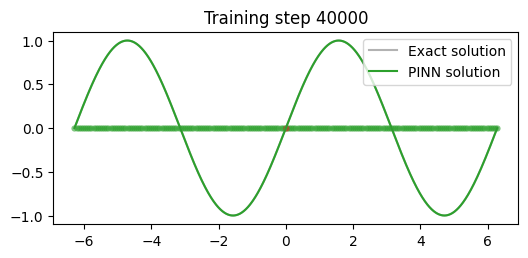

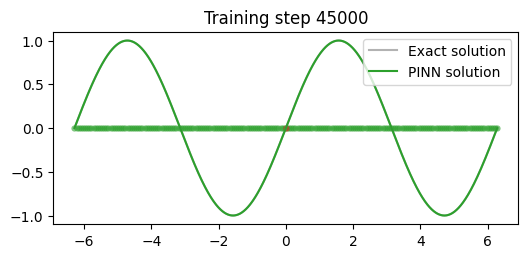

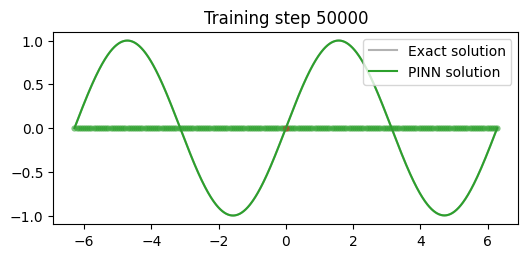

In [66]:
x, u_exact, u_pred, losses, errors = run(200, 1000, 1, (1, 1, 16, 2))

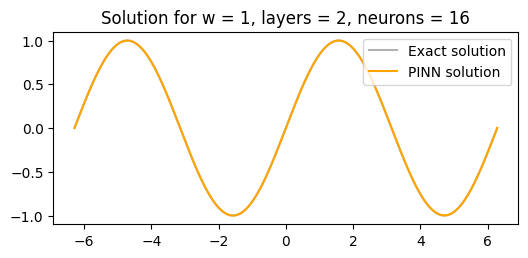

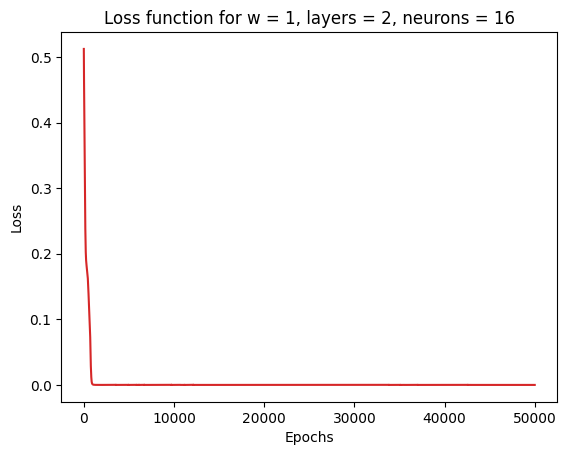

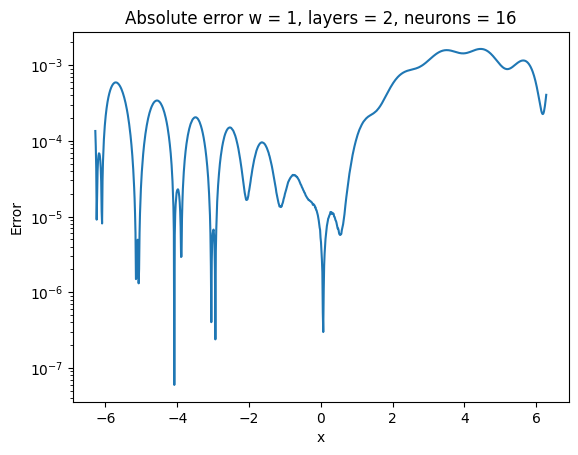

In [84]:
plot_solution(x, u_exact, u_pred, 1, 2, 16)
plot_losses(losses,  1, 2, 16)
plot_errors(x, u_exact, u_pred,  1, 2, 16)

### Obserwacje

W przypadku, gdy $\omega$ = 1 to nawet niewielka ilośc warstw ukrytych i neuronów w każdej warstwie pozwala na szybkie obliczenie rozwiązania, które jest bardzo zbliżone do prawidłowego. Widać to zarówno na wykresie funkcji kosztu, która już przy 5000 epoce jest bardzo bliska 0 oraz na wykresie błędu finalnego rozwiązania, który na całej dziedzinie jest bardzo niewielki.

## Podpunkt (b) $\omega$ = 15

In [68]:
pinn_configs = [(1, 1, 16, 2), (1, 1, 64, 4), (1, 1, 128, 5)]

### $\omega$ = 15, liczba warstw ukrytch = 2, liczba neuronów = 16

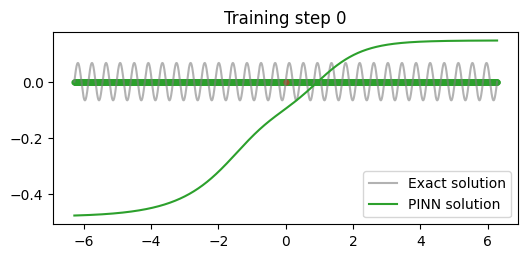

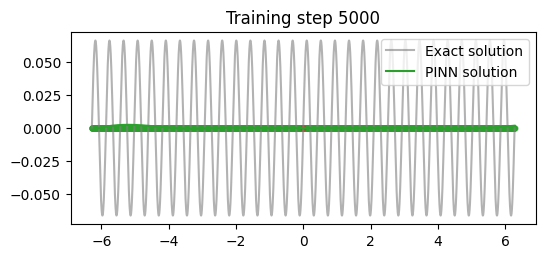

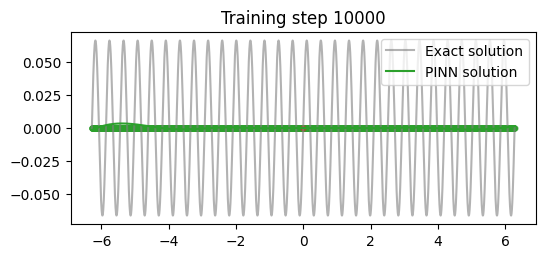

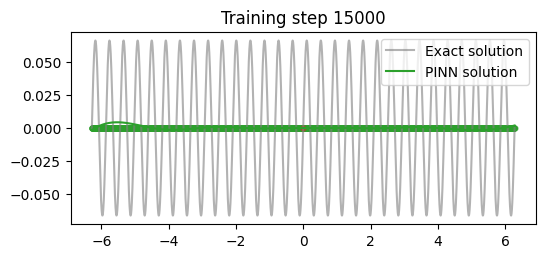

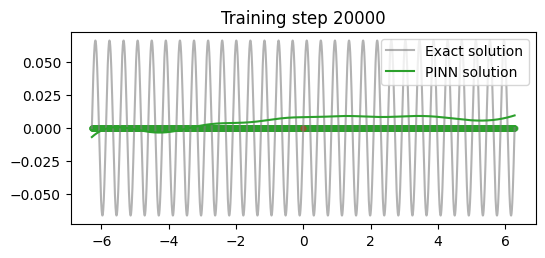

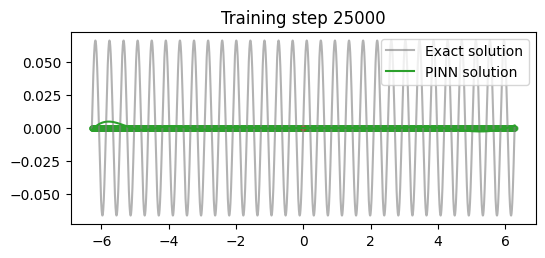

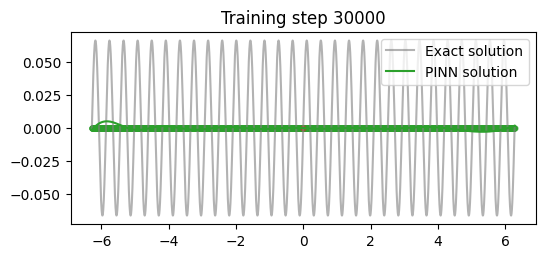

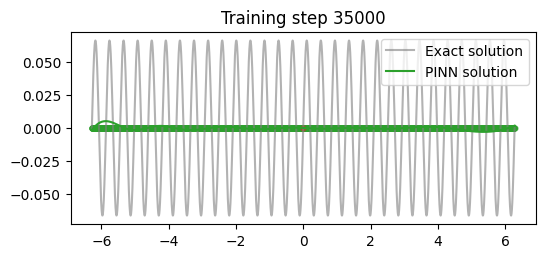

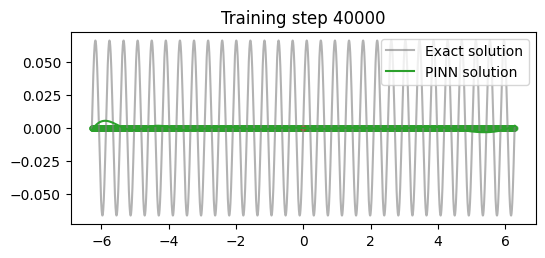

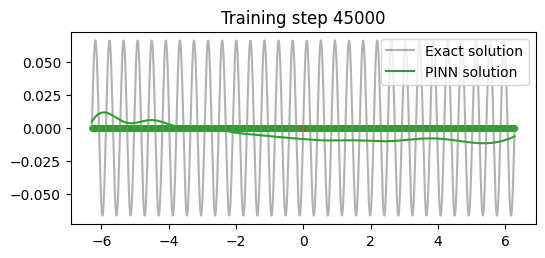

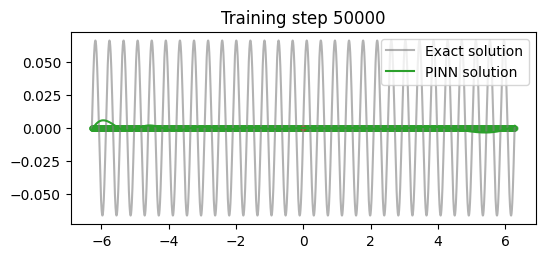

In [69]:
x_b1, u_exact_b1, u_pred_b1, losses_b1, errors_b1 = run(3000, 5000, 15, pinn_configs[0])

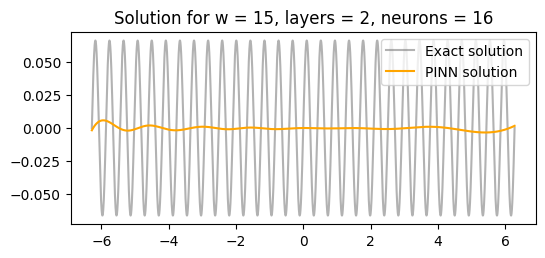

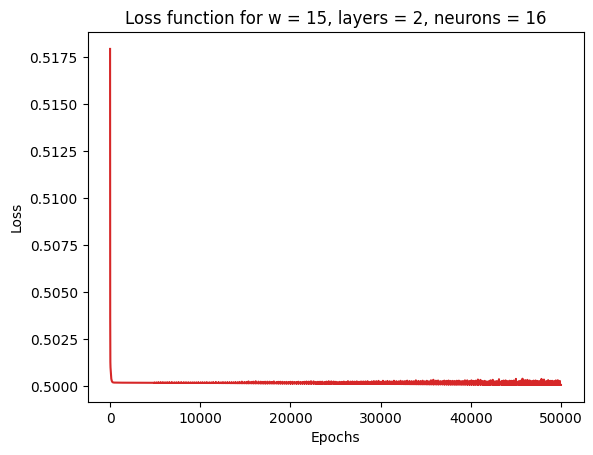

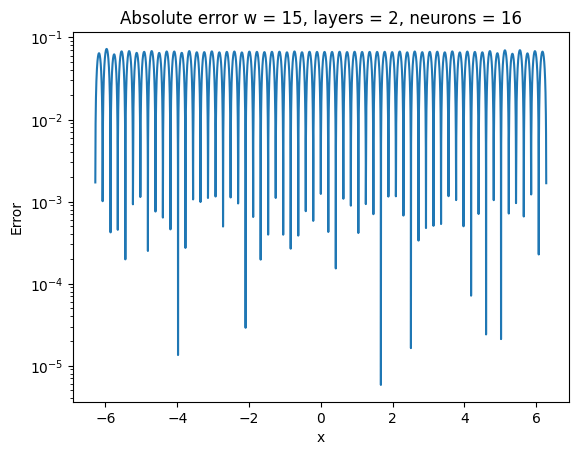

In [85]:
plot_solution(x_b1, u_exact_b1, u_pred_b1, 15, 2, 16)
plot_losses(losses_b1, 15, 2, 16)
plot_errors(x_b1, u_exact_b1, u_pred_b1, 15, 2, 16)

### Obserwacje

W przypadku, gdy $\omega$ = 15 to 2 warstwy ukryte i 16 neuronów w każdej warstwie są nie wystarczające, by przybliżyć prawidłowe rozwiązanie. Funkcja w tym przypadku oscyluje znacznie szybciej, więc sieć musi być zdolna do modelowania szybkich zmian w funkcji, co wymaga większej liczby warstw ukrytych lub neuronów w każdej warstwie. Nieprawidłowość rozwiązania modelu można zauważyć na wykresie funkcji kosztu, która stale utrzymuje się w okolicach 0.5 oraz na wykresie błędu, który na prawie całej dziedzinie jest duży.

### $\omega$ = 15, liczba warstw ukrytch = 4, liczba neuronów = 64

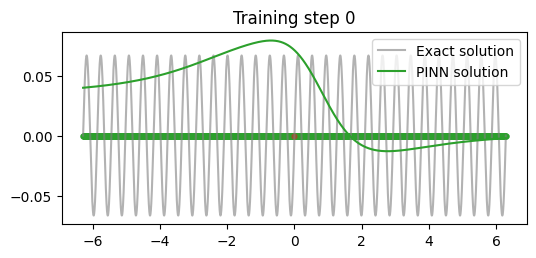

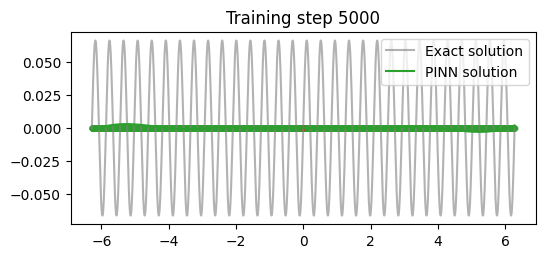

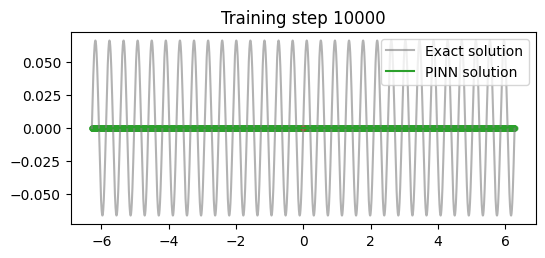

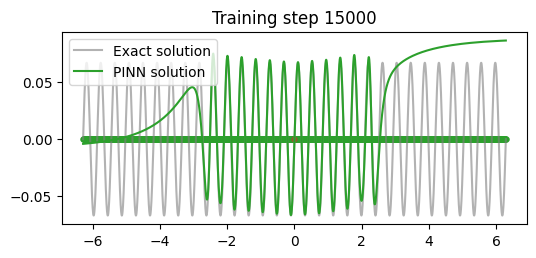

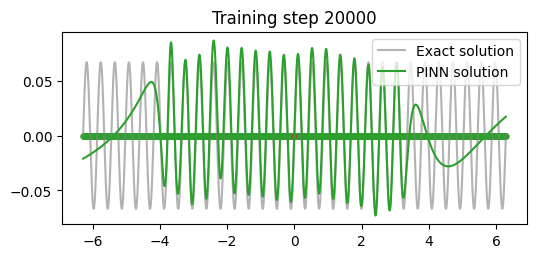

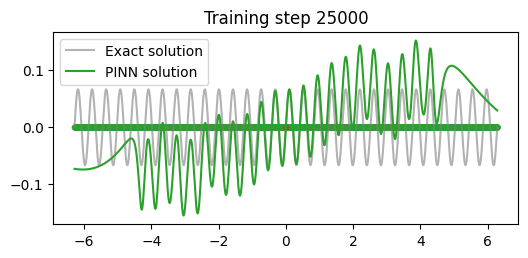

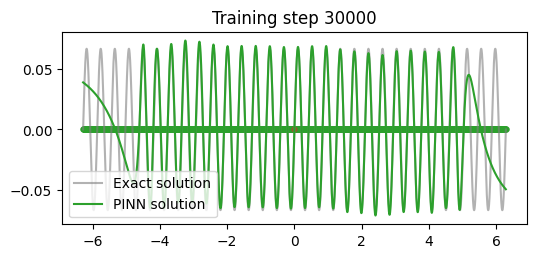

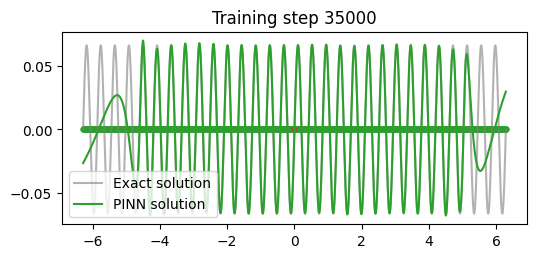

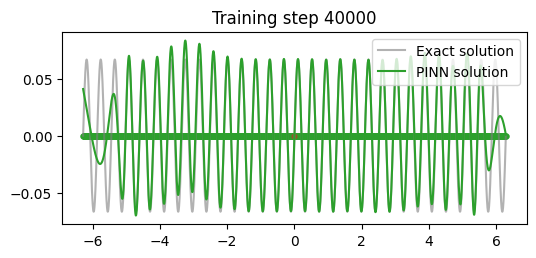

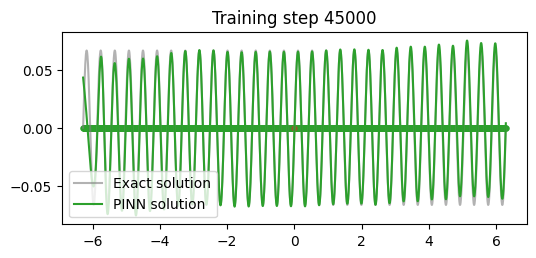

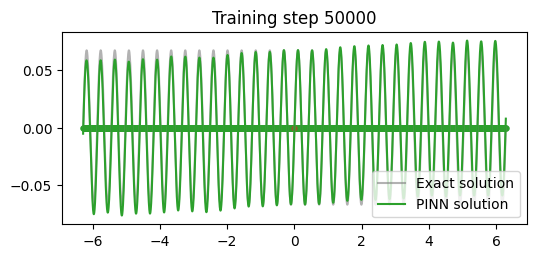

In [71]:
x_b2, u_exact_b2, u_pred_b2, losses_b2, errors_b2 = run(3000, 5000, 15, pinn_configs[1])

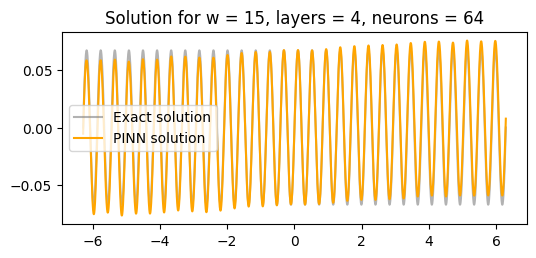

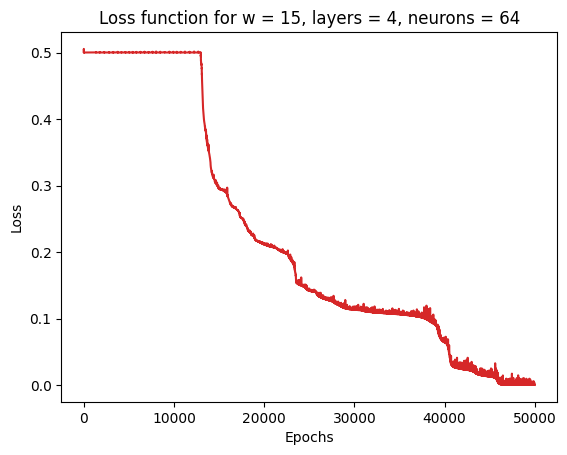

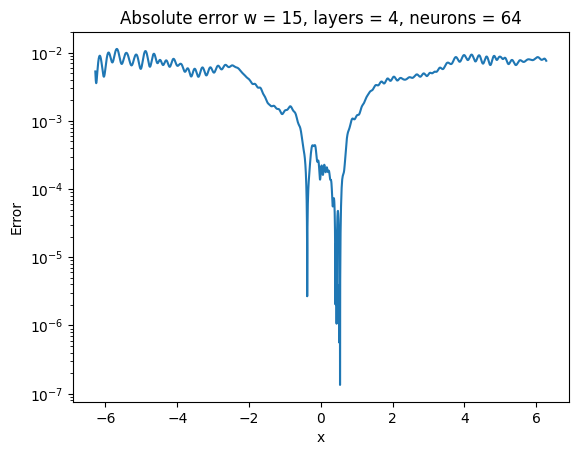

In [86]:
plot_solution(x_b2, u_exact_b2, u_pred_b2, 15, 4, 64)
plot_losses(losses_b2, 15, 4, 64)
plot_errors(x_b2, u_exact_b2, u_pred_b2, 15, 4, 64)

### Obserwacje

Gdy liczba warstw ukrytych została zwiększona dwukrotnie, a liczba neuronów czterokrotnie to rozwiązanie zostało obliczone znacznie dokładniej co można zauważyć na wykresie porównującym rozwiązanie sieci neuronowej z prawidłowym, a także na wykresie funkcji kosztu, która jest malejąca oraz na wykresie błedu, który jest niewielki na całej dziedzinie.

### $\omega$ = 15, liczba warstw ukrytch = 5, liczba neuronów = 128

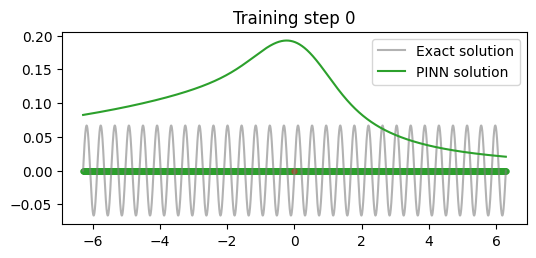

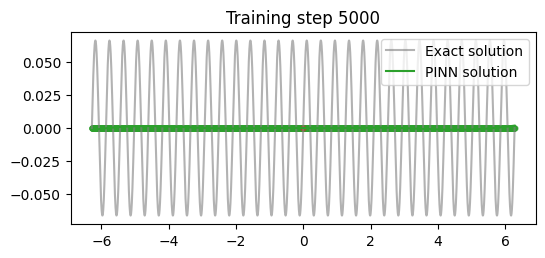

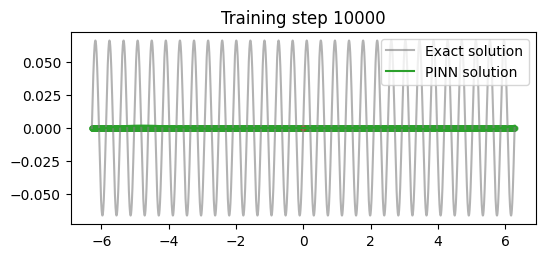

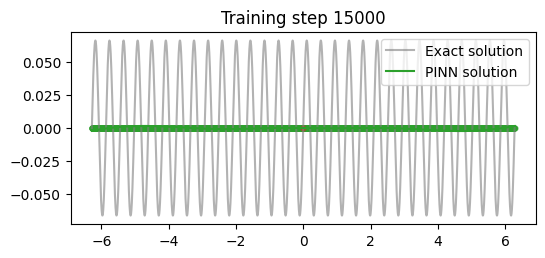

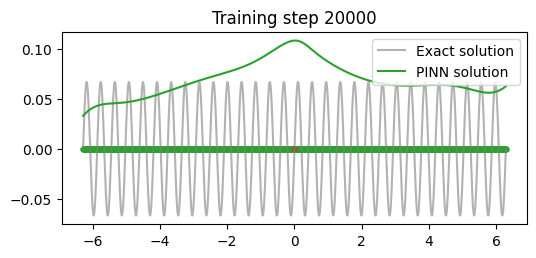

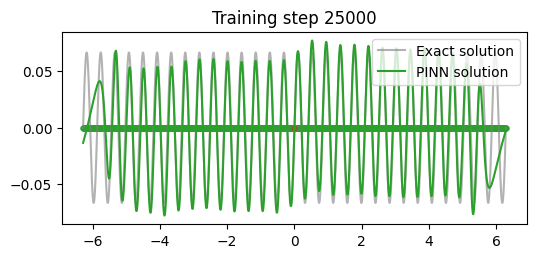

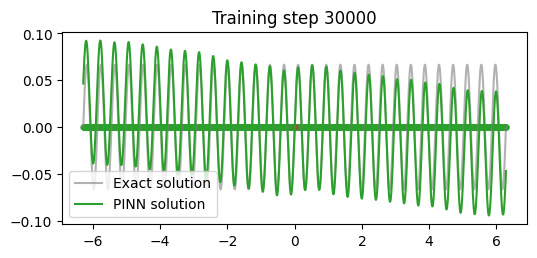

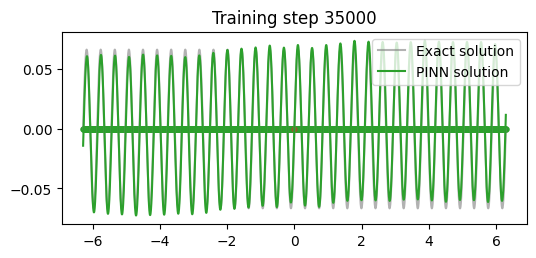

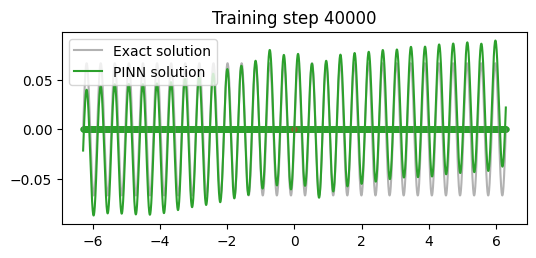

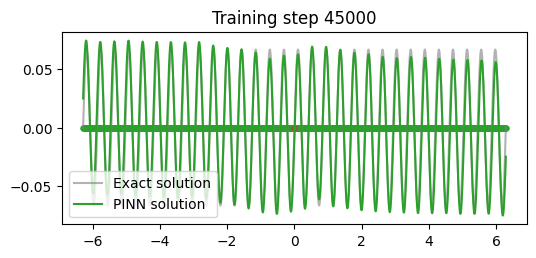

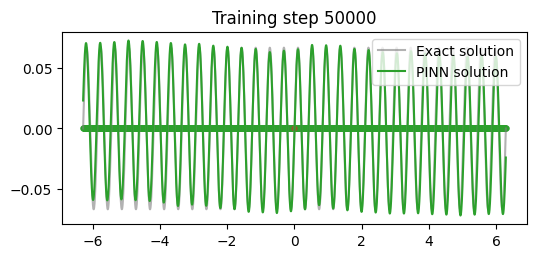

In [73]:
x_b3, u_exact_b3, u_pred_b3, losses_b3, errors_b3 = run(3000, 5000, 15, pinn_configs[2])

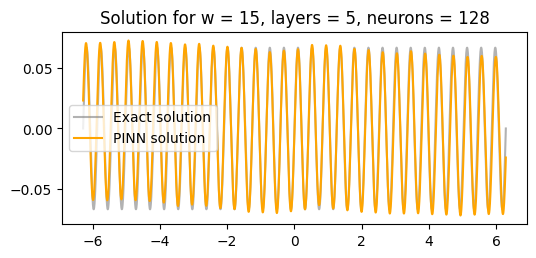

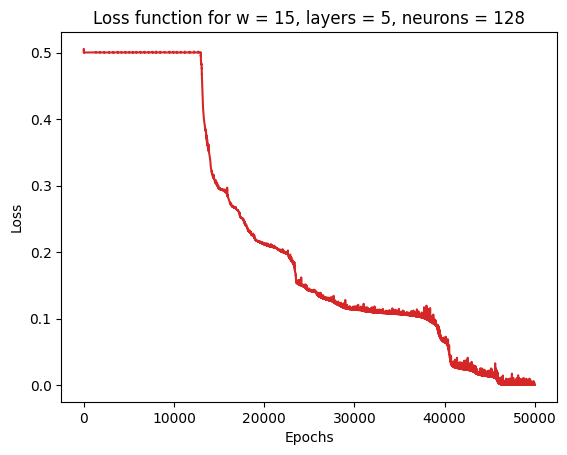

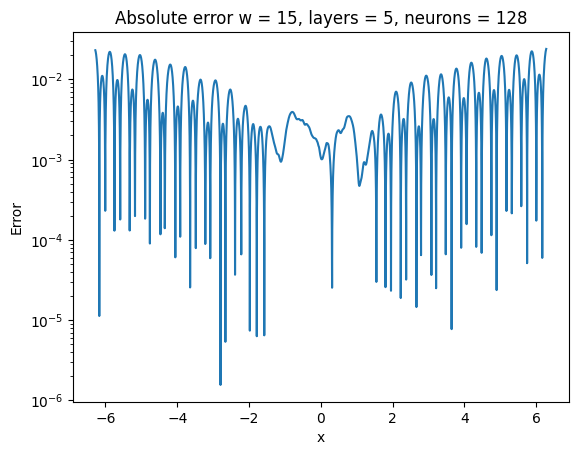

In [87]:
plot_solution(x_b3, u_exact_b3, u_pred_b3, 15, 5, 128)
plot_losses(losses_b2, 15, 5, 128)
plot_errors(x_b3, u_exact_b3, u_pred_b3, 15, 5, 128)

### Obserwacje
Gdy zwiększono liczbę neuronów do 128, a liczbę warstw ukrytych do 5 to rozwiązanie stało się jeszcze bardziej dokładne, co możemy zaobserwować na wykresach.

## Podpunkt (c) dla $\omega$ = 15, 4 warstw ukrytych i 64 neuronów w każdej warstwie

In [75]:
# modified FCN class:
class FCN_tanh(nn.Module):
    "Defines a fully-connected network in PyTorch"
    def __init__(self, N_INPUT, N_OUTPUT, N_HIDDEN, N_LAYERS, w):
        super().__init__()
        activation = nn.Tanh
        self.w = w
        self.fcs = nn.Sequential(*[
                        nn.Linear(N_INPUT, N_HIDDEN),
                        activation()])
        self.fch = nn.Sequential(*[
                        nn.Sequential(*[
                            nn.Linear(N_HIDDEN, N_HIDDEN),
                            activation()]) for _ in range(N_LAYERS-1)])
        self.fce = nn.Linear(N_HIDDEN, N_OUTPUT)
        
    def forward(self, x):
        x_nn = self.fcs(x)
        x_nn = self.fch(x_nn)
        x_nn = self.fce(x_nn)
        return torch.tanh(self.w * x) * x_nn


In [76]:
def run_tanh(train_num, test_num, w, pinn_config):
    torch.manual_seed(123)
    
    # define a neural network to train
    pinn = FCN_tanh(*pinn_config, w) 
    
    # define boundary points, for the boundary loss
    x_boundary = torch.tensor(0.).view(-1, 1).requires_grad_(True)
    
    # define training points over the entire domain, for the physics loss
    x_physics = torch.linspace(-2 * np.pi, 2 * np.pi, train_num).view(-1, 1).requires_grad_(True)
    
    # train the PINN
    x_test = torch.linspace(-2 * np.pi, 2 * np.pi, test_num).view(-1, 1)
    u_exact = exact_solution(x_test, w)
    optimiser = torch.optim.Adam(pinn.parameters(), lr=1e-3)
    
    losses = []
    errors = []

    for i in range(50_001):
        optimiser.zero_grad()

        # compute physics loss, which is equal to the total loss in this case
        u = pinn(x_physics)  # (30, 1)
        dudx = torch.autograd.grad(u, x_physics, torch.ones_like(u), create_graph=True)[0]  # (30, 1)
        residual = dudx - torch.cos(w * x_physics)
        loss = torch.mean(residual ** 2)

        # backpropagate joint loss, take optimiser step
        losses.append(loss.detach().numpy())
        loss.backward()
        optimiser.step()
        
        # compute error
        u = pinn(x_test).detach()
        error = np.abs(u - u_exact) / u_exact
        errors.append(error.detach().numpy())

        # plot the result as training progresses
        if i % 5000 == 0: 
            plt.figure(figsize=(6, 2.5))
            plt.scatter(x_physics.detach()[:, 0], torch.zeros_like(x_physics)[:, 0], s=20, lw=0, color="tab:green", alpha=0.6)
            plt.scatter(x_boundary.detach()[:, 0], torch.zeros_like(x_boundary)[:, 0], s=20, lw=0, color="tab:red", alpha=0.6)
            plt.plot(x_test[:, 0], u_exact[:, 0], label="Exact solution", color="tab:grey", alpha=0.6)
            plt.plot(x_test[:, 0], u[:, 0], label="PINN solution", color="tab:green")
            plt.title(f"Training step {i}")
            plt.legend()
            plt.show()
            
    return x_test, u_exact, u, losses, errors

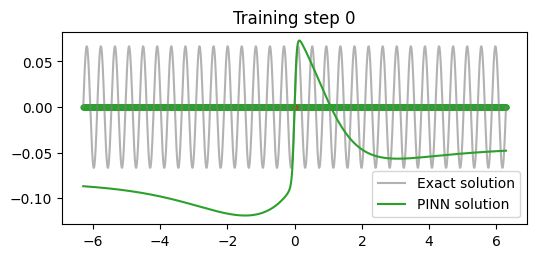

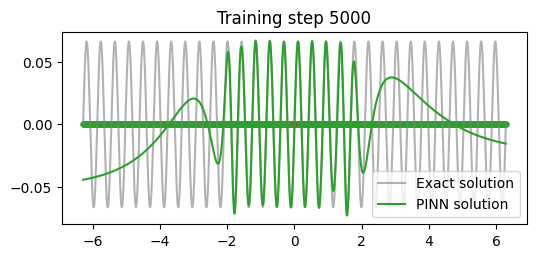

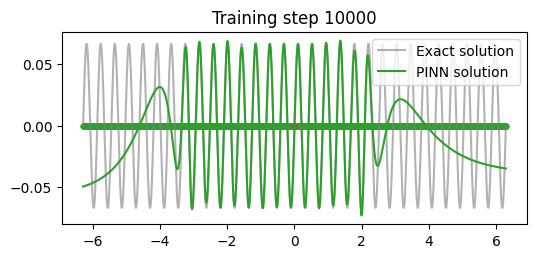

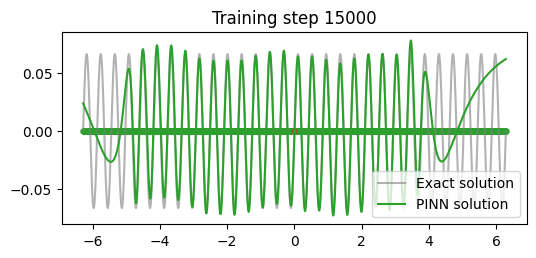

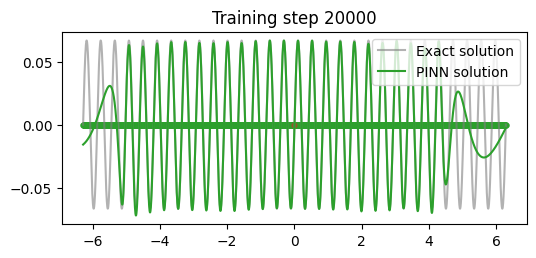

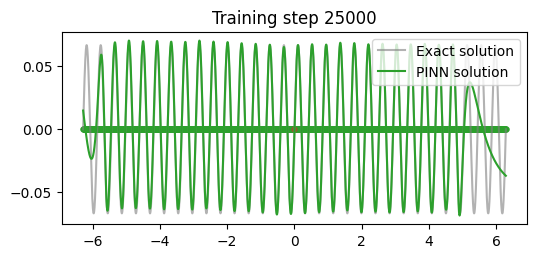

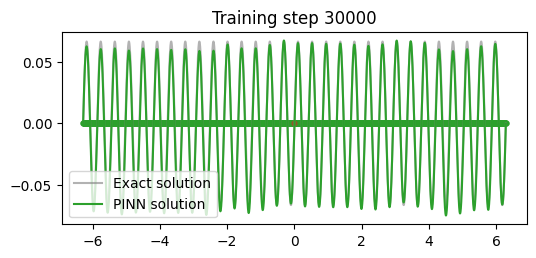

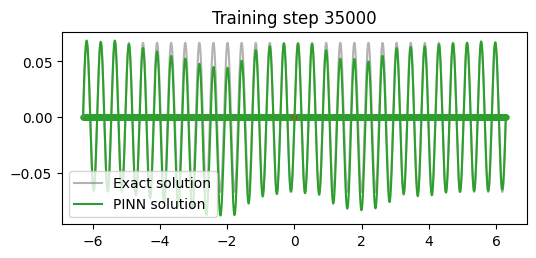

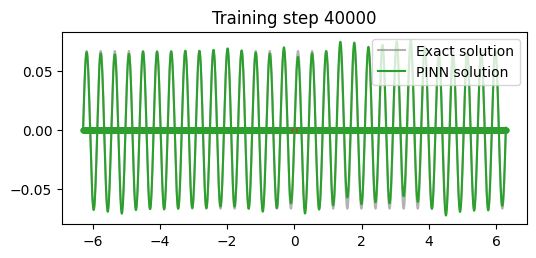

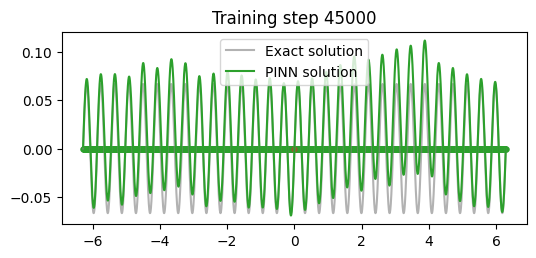

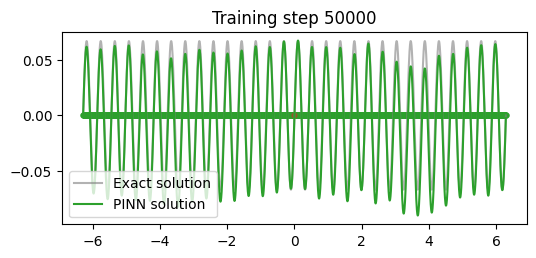

In [77]:
x_b2_c, u_exact_b2_c, u_pred_b2_c, losses_b2_c, errors_b2_c = run_tanh(3000, 5000, 15, pinn_configs[1])

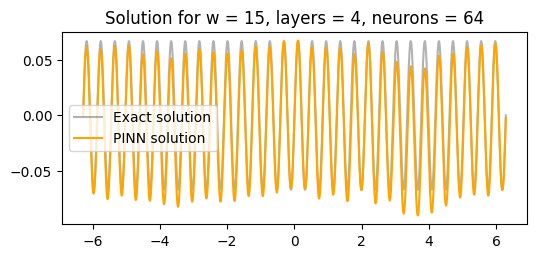

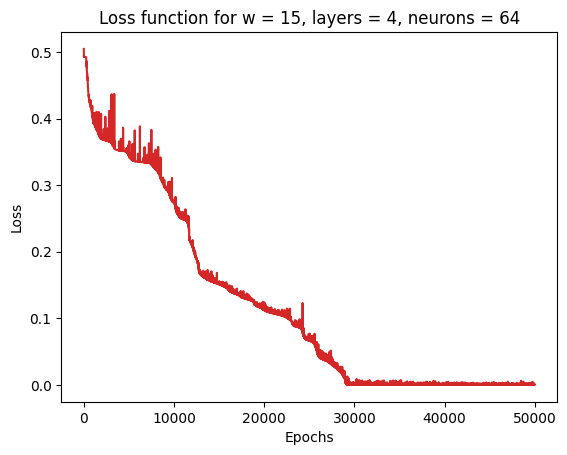

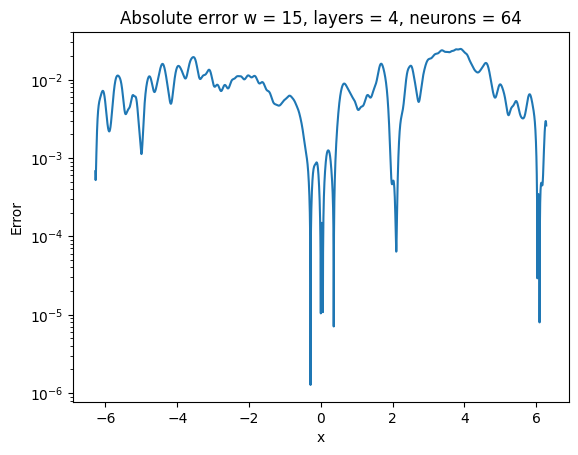

In [88]:
u_exact_b2_c = exact_solution(x_b2_c, 15)
plot_solution(x_b2_c, u_exact_b2_c, u_pred_b2_c, 15, 4, 64)
plot_losses(losses_b2_c, 15, 4, 64)
plot_errors(x_b2_c, u_exact_b2_c, u_pred_b2_c, 15, 4, 64)

Rozwiązanie modelu, w którym szukane rozwiązanie (ansatz) ma postać:
u(x; θ) = tanh(ωx) ·NN(x; θ) również zostało poprawnie przybliżone i jest bardzo podobne do rozwiązania bez tego warunku, jednak różnice można zauważyć porównując wykresy funckji kosztu, która w tym przypadku już od początku maleje w przeciwieństwie do poprzedniego przypadku.

## Wnioski
Podczas analizy wyników wysnuć można następujące wnioski:

Wartoś $\omega$ funkcji ma duży wpływ na modelowanie: </br>

- Dla $\omega$ = 1 sieć z dwiema warstwami ukrytymi i 16 neuronami była w stanie efektywnie nauczyć się i modelować funkcję, to sugeruje, że dla funkcji o stosunkowo niskiej częstotliwości oscylacji, prosta architektura sieci może być wystarczająca do osiągnięcia dobrych wyników. </br>

- Dla $\omega$ = 15 funkcja oscyluje znacznie szybciej, co wymaga bardziej złożonych sieci do dokładnego modelowania. Porównując różne konfiguracje: </br>
    - Sieć z 2 warstwami i 16 neuronami miała trudności z nauczeniem się odpowiednich funkcji, co mogło skutkować niedostatecznym modelowaniem szybkich oscylacji. </br>
    - Sieci z 4 warstwami i 64 neuronami oraz z 5 warstwami i 128 neuronami lepiej radziły sobie z zadaniami modelowania, ponieważ zwiększona liczba warstw ukrytych i liczba neuronów w każdej warstwie pomogła w uchwyceniu skomplikowanych wzorców oscylacji, co przełożyło się na wyższą dokładność modeli. </br>

Dodatkowo przy analizie wyników eksperymentu, gdzie szukane rozwiązanie (ansatz) ma postać u(x; θ) = tanh(ωx) ·NN(x; θ), a siec ma 4 warstwy ukryte i 64 neurony, można zaobserować następujące wnioski:
Zastosowanie tej funkcji automatycznie zapewnia, że 𝑢^(0)=0 to podejście eliminuje potrzebę dodatkowych składników w funkcji kosztu służących do wymuszenia tego warunku, co upraszcza model i potencjalnie redukuje ryzyko błędów związanych z narzucaniem tych warunków. Stosując modyfikację ansatzu, można zaobserwować różnice w dokładności i zachowaniu modelu w porównaniu do klasycznych formułowań sieci neuronowej.

## Bibliografia

Prezentacja "Physics-informed Neural Networks" - Marcin Kuta </br>

Maziar Raissi, Paris Perdikaris, George Em Karniadakis
Physics Informed Deep Learning (Part I): Data-driven
Solutions of Nonlinear Partial Differential Equations </br>